<a href="https://colab.research.google.com/github/Ananda948/YahooPrice-Forecasting/blob/main/YahooPrice_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. LOAD DATASET

# Import library yang diperlukan
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import seaborn as sns
from google.colab import drive

# Mount Google Drive
drive.mount("/content/drive")

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/yahooDataset/yahoo_stock.csv")

# Menampilkan tipe data dan 5 baris pertama
print(f"Dataset type: {type(df)}")
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset type: <class 'pandas.core.frame.DataFrame'>
         Date         High          Low         Open        Close  \
0  2015-11-23  2095.610107  2081.389893  2089.409912  2086.590088   
1  2015-11-24  2094.120117  2070.290039  2084.419922  2089.139893   
2  2015-11-25  2093.000000  2086.300049  2089.300049  2088.870117   
3  2015-11-26  2093.000000  2086.300049  2089.300049  2088.870117   
4  2015-11-27  2093.290039  2084.129883  2088.820068  2090.110107   

         Volume    Adj Close  
0  3.587980e+09  2086.590088  
1  3.884930e+09  2089.139893  
2  2.852940e+09  2088.870117  
3  2.852940e+09  2088.870117  
4  1.466840e+09  2090.110107  


In [ ]:
# 2. PRE-PROCESSING DATASET

# Mengatasi nilai yang hilang dengan metode forward fill
df.fillna(method='ffill', inplace=True)

# Memeriksa apakah masih ada nilai yang hilang
missing_values = df.isnull().sum()
print("Jumlah nilai yang hilang setelah pengisian:")
print(missing_values)

# Konversi kolom Date ke format datetime
df['Date'] = pd.to_datetime(df['Date'])

# Menetapkan kolom Date sebagai index
df.set_index('Date', inplace=True)

# Handling outliers menggunakan metode IQR
numerical_columns = ['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']
for column in numerical_columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

# Menampilkan statistik deskriptif setelah penanganan outliers
print(df.describe())

Jumlah nilai yang hilang setelah pengisian:
Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64
              High          Low         Open        Close        Volume  \
count  1825.000000  1825.000000  1825.000000  1825.000000  1.825000e+03   
mean   2660.718673  2632.817580  2647.704751  2647.856284  3.778224e+09   
std     409.680853   404.310068   407.169994   407.301177  7.988013e+08   
min    1847.000000  1810.099976  1833.400024  1829.079956  1.930600e+09   
25%    2348.350098  2322.250000  2341.979980  2328.949951  3.257950e+09   
50%    2696.250000  2667.840088  2685.489990  2683.340088  3.609740e+09   
75%    2930.790039  2900.709961  2913.860107  2917.520020  4.142850e+09   
max    3645.989990  3600.159912  3612.090088  3626.909912  5.470200e+09   

         Adj Close  
count  1825.000000  
mean   2647.856284  
std     407.301177  
min    1829.079956  
25%    2328.949951  
50%    2683.340088  
75%    2917.520

<ipython-input-16-156604c30753>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [ ]:
# 3. MODEL SARIMA

# Membagi data menjadi data latih (train) dan data uji (test)
train_size = int(len(df) * 0.8)
train, test = df['Close'][:train_size], df['Close'][train_size:]

# Identifikasi parameter musiman
seasonal_order = (1, 1, 1, 12)  # (P, D, Q, S) untuk musiman
d = 1  # Differencing non-musiman
q = 1  # MA non-musiman
p = 1  # AR non-musiman

# Membuat model SARIMA
sarima_model = SARIMAX(train, order=(p, d, q), seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
sarima_model_fit = sarima_model.fit()
print(sarima_model_fit.summary())

# Memprediksi menggunakan SARIMA
sarima_forecast = sarima_model_fit.forecast(steps=len(df))  # Prediksi untuk keseluruhan data

# Pastikan sarima_forecast berbentuk array numpy
sarima_forecast = np.array(sarima_forecast).reshape(-1, 1)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 1460
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -6137.792
Date:                            Thu, 12 Dec 2024   AIC                          12285.584
Time:                                    06:50:20   BIC                          12311.921
Sample:                                11-23-2015   HQIC                         12295.418
                                     - 11-21-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0810      0.423     -0.192      0.848      -0.910       0.748
ma.L1          0.0346      0.424   

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1765/1765 ━━━━━━━━━━━━━━━━━━━━ 60s 32ms/step - loss: 0.0065
Epoch 2/10
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 56s 32ms/step - loss: 0.0012
Epoch 3/10
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 80s 31ms/step - loss: 9.2215e-04
Epoch 4/10
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 83s 31ms/step - loss: 4.7198e-04
Epoch 5/10
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 58s 33ms/step - loss: 5.9124e-04
Epoch 6/10
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 79s 31ms/step - loss: 5.3562e-04
Epoch 7/10
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - loss: 5.5882e-04
Epoch 8/10
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 81s 31ms/step - loss: 3.9920e-04
Epoch 9/10
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 58s 33ms/step - loss: 6.5006e-04
Epoch 10/10
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 79s 31ms/step - loss: 4.7875e-04
Available keys in history: dict_keys(['loss'])


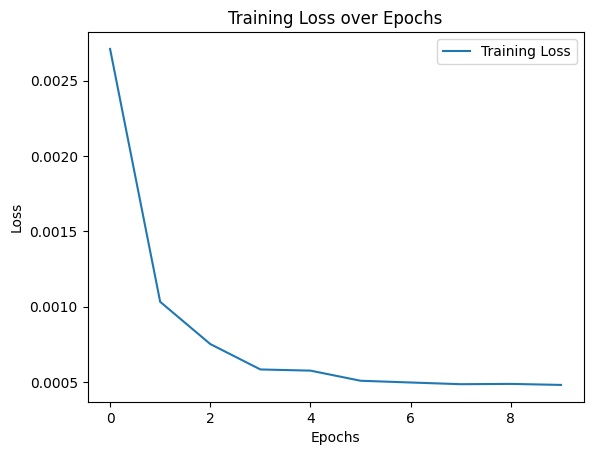

In [ ]:
# 4. MODEL LSTM

# Pra-pemrosesan untuk LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

# Normalisasi prediksi SARIMA menggunakan scaler yang sama
scaled_sarima = scaler.transform(sarima_forecast)

# Membuat dataset untuk pelatihan LSTM
X_train, y_train = [], []
window_size = 60

# Loop untuk membuat X_train dan y_train
for i in range(window_size, len(scaled_data)):
    data_slice = scaled_data[i-window_size:i, 0].reshape(-1, 1)
    sarima_slice = scaled_sarima[i-window_size:i, 0].reshape(-1, 1)

    # Memastikan panjang slice konsisten
    if data_slice.shape[0] == sarima_slice.shape[0]:
        X_train.append(np.hstack((data_slice, sarima_slice)))
        y_train.append(scaled_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape data untuk input LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 2)

# Membuat model LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dense(units=25))
lstm_model.add(Dense(units=1))

# Compile model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train model (dengan epochs lebih banyak)
history = lstm_model.fit(X_train, y_train, batch_size=1, epochs=10)

# Cek apakah 'loss' ada di history
print("Available keys in history:", history.history.keys())

# Plot Training Loss
if 'loss' in history.history:
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title("Training Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
else:
    print("Key 'loss' not found in history.history")

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step
RMSE: 52.991639492716686
MAE: 33.26696497182377
MAPE: 1.115190480804957%
R² Score: 0.9679304418259377


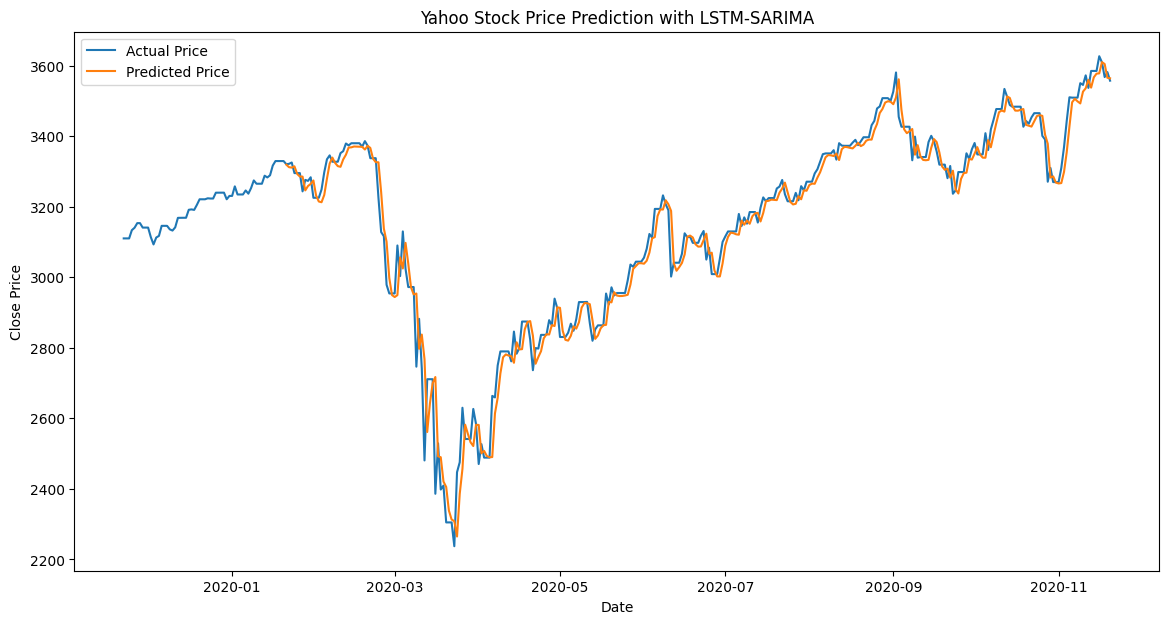

In [ ]:
# 5. EVALUASI DAN VISUALISASI HASIL PREDIKSI

# Menyiapkan data uji untuk LSTM
scaled_test = scaler.transform(test.values.reshape(-1, 1))

# Ubah sarima_forecast menjadi NumPy array sebelum reshape
# scaled_sarima_test = scaler.transform(sarima_forecast.to_numpy().reshape(-1, 1))
scaled_sarima_test = scaler.transform(sarima_forecast.reshape(-1, 1)) # Removing to_numpy() as sarima_forecast is already a NumPy array


X_test, y_test = [], []
for i in range(window_size, len(scaled_test)):
    X_test.append(np.hstack((scaled_test[i-window_size:i, 0].reshape(-1, 1),
                             scaled_sarima_test[i-window_size:i, 0].reshape(-1, 1))))
    y_test.append(scaled_test[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 2)

# Memprediksi menggunakan LSTM
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Evaluasi model
# Pastikan test[window_size:] di-inverse_transform agar dalam skala yang sama
actual_test = scaler.inverse_transform(scaled_test[window_size:])  # Ubah jika diperlukan

rmse = np.sqrt(mean_squared_error(actual_test, lstm_predictions))
print(f"RMSE: {rmse}")
mae = mean_absolute_error(actual_test, lstm_predictions)
print(f"MAE: {mae}")
mape = np.mean(np.abs((actual_test - lstm_predictions) / actual_test)) * 100
print(f"MAPE: {mape}%")
r2 = r2_score(actual_test, lstm_predictions)
print(f"R² Score: {r2}")

# Visualisasi hasil
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(test):], test, label="Actual Price")  # Pastikan 'test' adalah data asli
plt.plot(df.index[-len(test) + window_size:], lstm_predictions, label="Predicted Price")
plt.title("Yahoo Stock Price Prediction with LSTM-SARIMA")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

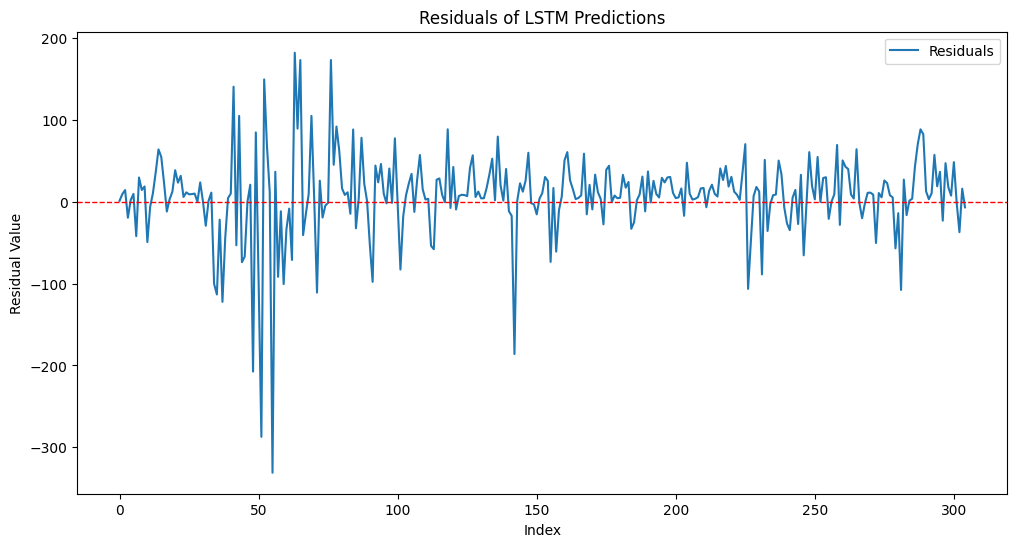

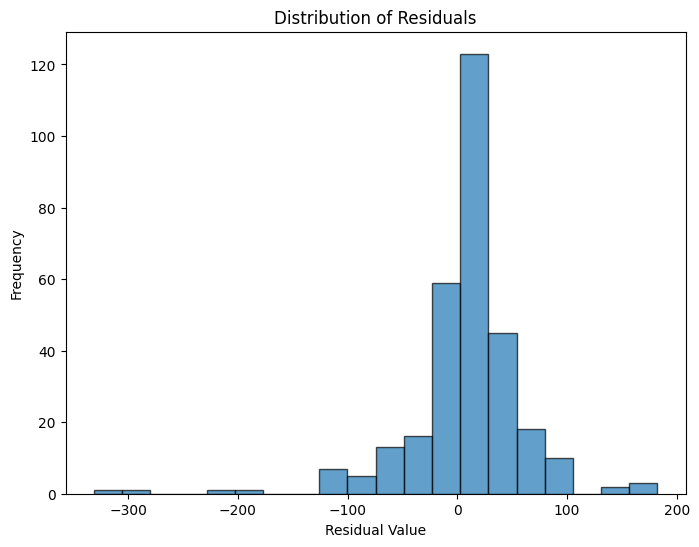

In [ ]:
# 6. RESIDUAL ANALYSIS
# Analisis residuals (selisih antara harga yang diprediksi dan harga aktual) untuk mengevaluasi kualitas model lebih lanjut.

# Pastikan test[window_size:] di-inverse_transform jika test dinormalisasi
actual_test = scaler.inverse_transform(scaled_test[window_size:])  # Jika diperlukan

# Hitung residuals
residuals = actual_test.flatten() - lstm_predictions.flatten()

# Residual Analysis: Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals')
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Garis nol sebagai referensi
plt.title("Residuals of LSTM Predictions")
plt.xlabel("Index")
plt.ylabel("Residual Value")
plt.legend()
plt.show()

# Histogram Residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, edgecolor='black', alpha=0.7)
plt.title("Distribution of Residuals")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.show()